In [1]:
import tensorflow as tf
import tensorflow.keras as keras
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns; sns.set()
%config InlineBackend.figure_format = 'retina'
from sklearn.metrics import mean_absolute_error, mean_squared_error
from sklearn.preprocessing import StandardScaler,MinMaxScaler
from sklearn.model_selection import train_test_split

In [2]:
data = pd.read_csv('ads_hour.csv', index_col=['Date'], parse_dates=['Date'])

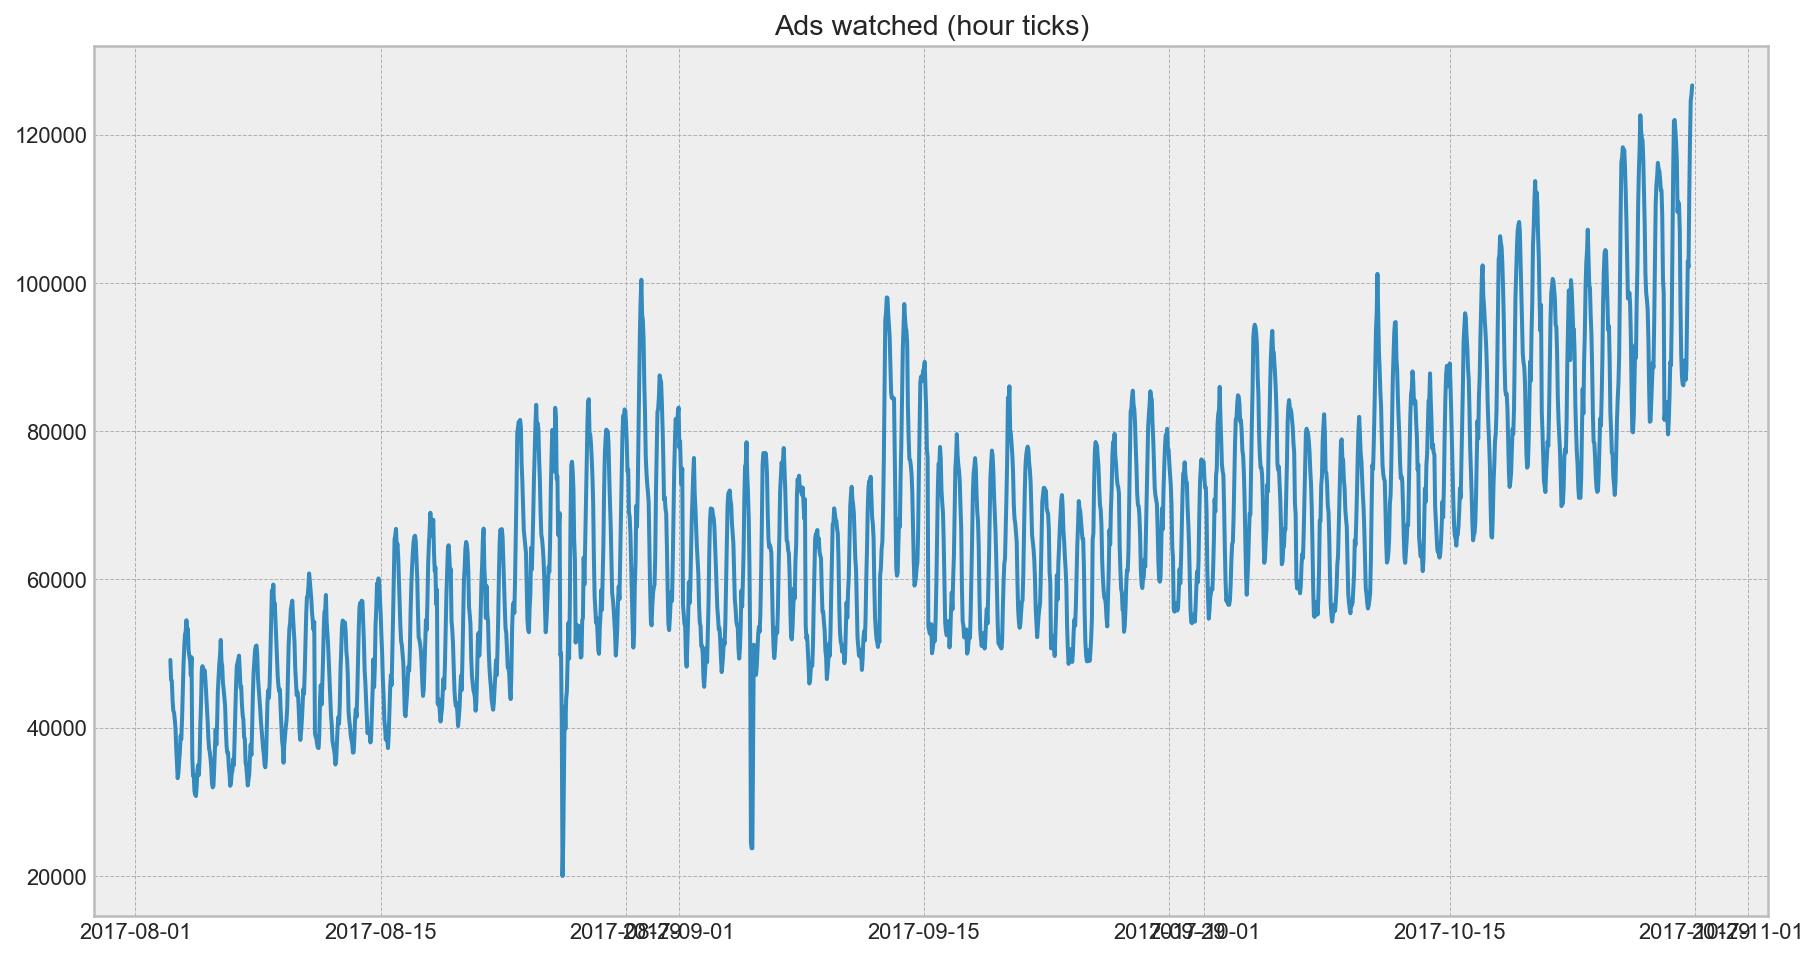

In [3]:
with plt.style.context('bmh'):    
    plt.figure(figsize=(15, 8))
    plt.title('Ads watched (hour ticks)')
    plt.plot(data.ads);

In [4]:
scaler = MinMaxScaler()
data = scaler.fit_transform(data)

In [5]:
data.shape

(2085, 1)

In [6]:
n_steps = 36 # number of hour to give as input
steps_ahead = 12 # number of hour to predict
size = data.shape[0]-n_steps-steps_ahead+1

In [37]:
serie = np.empty((size, n_steps+steps_ahead, 1))
for i in range(size):
    serie[i,:,:] = data[i:i+n_steps+steps_ahead]
X = serie[:, :n_steps]

Y = np.empty((size, n_steps, steps_ahead))
for step_ahead in range(1, steps_ahead + 1):
    Y[:, :, step_ahead - 1] = serie[:, step_ahead:step_ahead + n_steps, 0]
    
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.25,shuffle=False ,random_state=42)
serie.shape,Y_train.shape,X_train.shape

((2038, 48, 1), (1528, 36, 12), (1528, 36, 1))

In [9]:
def last_time_step_mse(Y_true, Y_pred):
    return keras.metrics.mean_squared_error(Y_true[:, -1], Y_pred[:, -1])
def mean_absolute_percentage_error(y_true, y_pred): 
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

In [10]:
model = keras.models.Sequential()
model.add(keras.layers.InputLayer(input_shape=[None, 1]))
for rate in (1, 2, 4, 8) * 2:
    model.add(keras.layers.Conv1D(filters=20, kernel_size=2, padding="causal",
                                  activation="relu", dilation_rate=rate))
model.add(keras.layers.Conv1D(filters=steps_ahead, kernel_size=1))
model.compile(loss="mse", optimizer="adam", metrics=[last_time_step_mse])

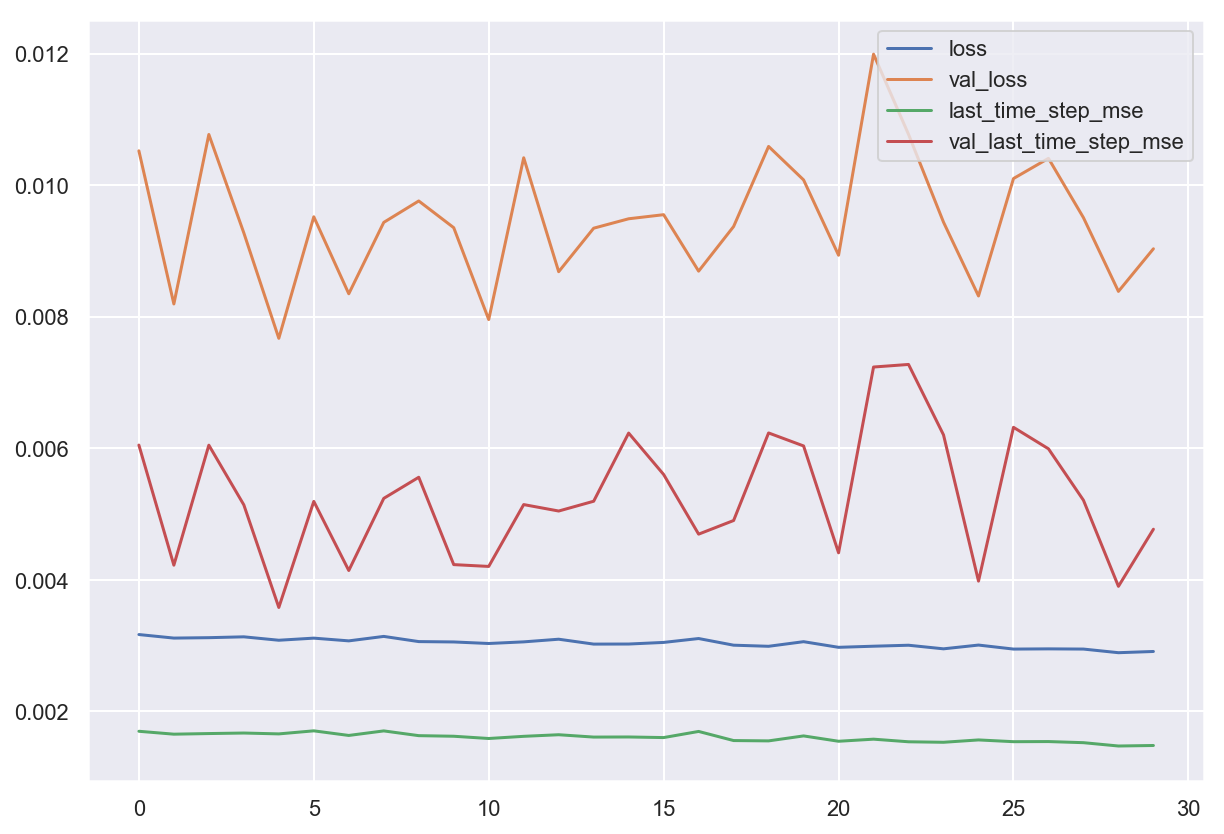

In [38]:
history = model.fit(X_train, Y_train, epochs=30,validation_data=(X_test, Y_test),verbose = 0)
plt.figure(figsize=(10,7))
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.plot(history.history['last_time_step_mse'])
plt.plot(history.history['val_last_time_step_mse'])
plt.legend(['loss','val_loss','last_time_step_mse','val_last_time_step_mse'])

In [45]:
# model.save_weights('checkpoint/ckpt'+str(n_steps)+str(steps_ahead))
# model.load_weights('checkpoint/ckpt'+str(n_steps)+str(steps_ahead))

### Prediction on the test set

In [39]:
pred = model.predict(X_test)

### Result on one test instance

In [40]:
# Interactive test
import plotly.graph_objects as go
from ipywidgets import interact
tot_pred = steps_ahead + n_steps
idx = Y_test.shape[0]-1
plot_y = np.empty((idx, tot_pred))
plt_pred = np.empty((idx, tot_pred))
plot_y = np.hstack((Y_test[:,:,0],Y_test[:,n_steps-1,:]))
plt_pred = np.hstack((pred[:,:,0],pred[:,n_steps-1,:]))
fig1= go.FigureWidget()
fig1.add_scatter(name="True")
fig1.add_scatter(name="Pred")
@interact(index=(0,plot_y.shape[0]-1,1))
def update(index = 0):
    fig1.data[0].y= plot_y[index,:]
    fig1.data[1].y= plt_pred[index,:]
fig1

interactive(children=(IntSlider(value=0, description='index', max=509), Output()), _dom_classes=('widget-inter…

FigureWidget({
    'data': [{'name': 'True',
              'type': 'scatter',
              'uid': '68c453d6-0…

In [44]:
fig= go.FigureWidget()
fig.add_scatter(name="True")
fig.add_scatter(name="Pred")
@interact(step_ahead=(0,steps_ahead-1,1),nb_input = (0,n_steps-1,1))
def update(step_ahead = 0,nb_input=49):
    true = Y_test[:,nb_input,step_ahead]
    pre = pred[:,nb_input,step_ahead]
    fig.data[0].y= true
    fig.data[1].y= pre
    mae  = mean_absolute_error(pre, true)
    mape = mean_absolute_percentage_error(pre, true)
    fig.layout.title = ("MAE {}, MAPE {}%".format(round(mae,4), round(mape, 2)))
fig

interactive(children=(IntSlider(value=0, description='step_ahead', max=11), IntSlider(value=35, description='n…

FigureWidget({
    'data': [{'name': 'True',
              'type': 'scatter',
              'uid': '609e048f-1…

##
=Result on test set

Text(0.5, 1.0, 'MAE 7630.0, MAPE 9.64%')

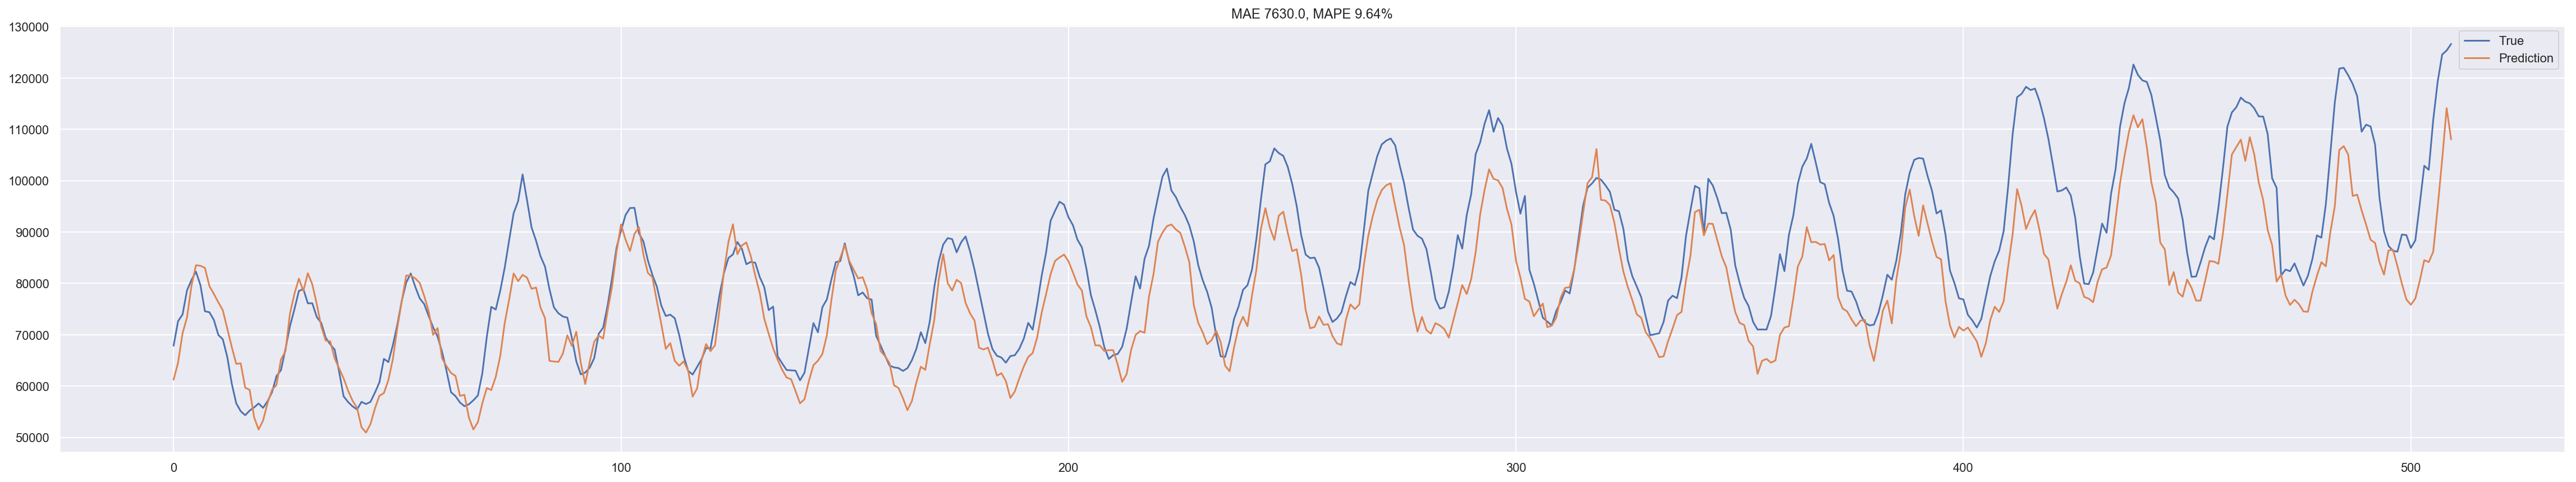

In [42]:
pred1 = np.empty((idx))
pred1 = scaler.inverse_transform(pred[:,n_steps-1,steps_ahead-1].reshape(-1,1))
y1 = scaler.inverse_transform(Y_test[:,n_steps-1,steps_ahead-1].reshape(-1,1))

mae  = mean_absolute_error(pred1, y1)
mape = mean_absolute_percentage_error(pred1, y1)

plt.figure(figsize=(40,7))
plt.plot(y1)
plt.plot(pred1)
plt.legend(labels=['True','Prediction'])
plt.title("MAE {}, MAPE {}%".format(round(mae), round(mape, 2)))

## Result on the whole dataset

Text(0.5, 1.0, 'MAE 4536.0, MAPE 6.68%')

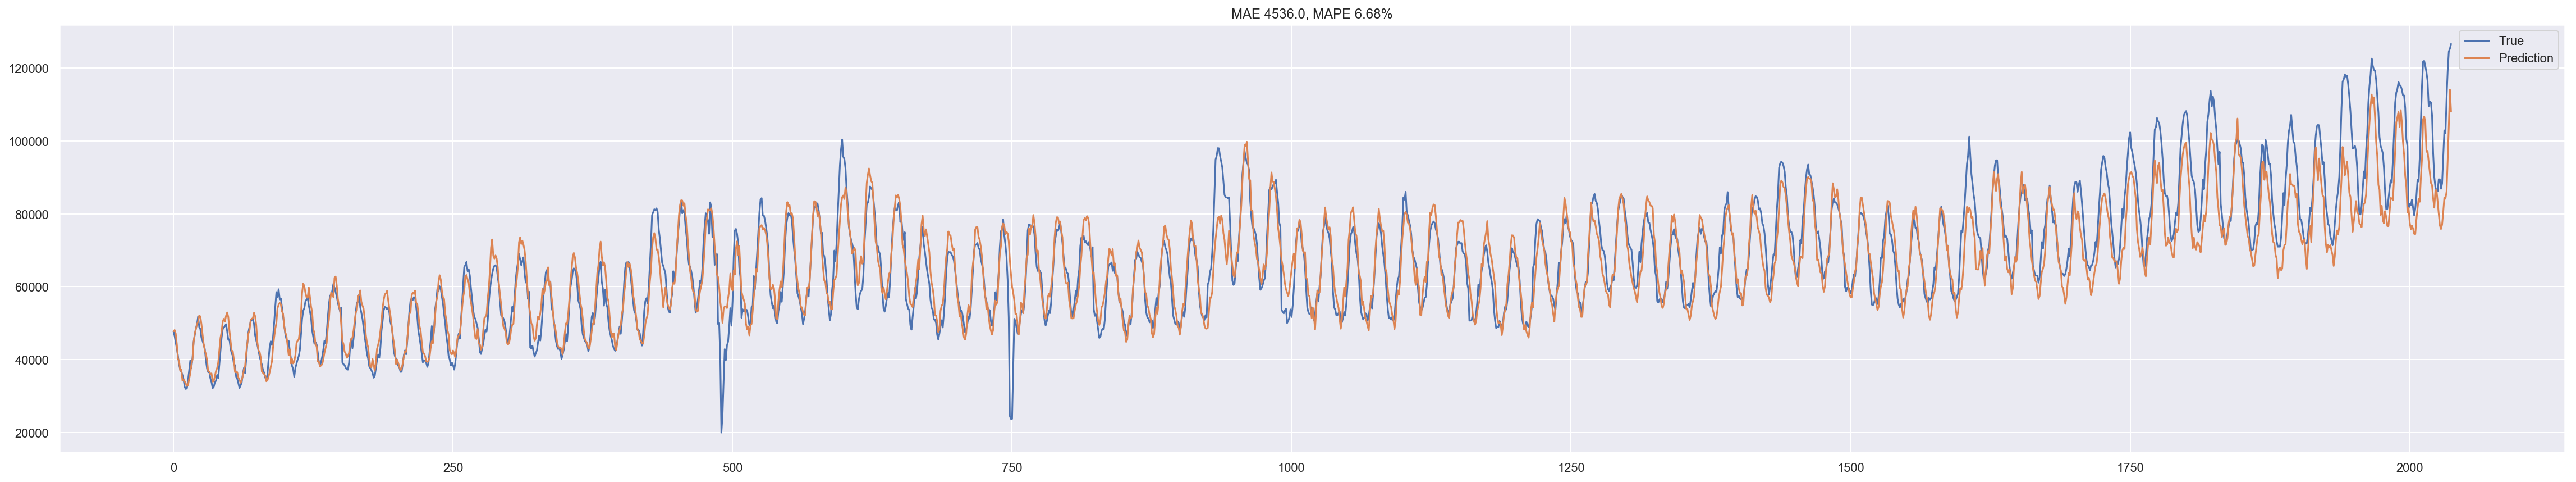

In [43]:
full_pred=model.predict(X)
plt.figure(figsize=(40,7))
step_ahead = steps_ahead
plot_Y = scaler.inverse_transform(Y[:,n_steps-1,step_ahead-1].reshape(-1,1))
plot_pred = scaler.inverse_transform(full_pred[:,n_steps-1,step_ahead-1].reshape(-1,1))

mae  = mean_absolute_error(plot_pred, plot_Y)
mape = mean_absolute_percentage_error(plot_pred, plot_Y)

plt.plot(plot_Y)
plt.plot(plot_pred)
plt.legend(labels=['True','Prediction'])
plt.title("MAE {}, MAPE {}%".format(round(mae), round(mape, 2)))